### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import numpy as np
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [0]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

###Utilities functions

In [0]:
def get_key(lst):
  """return the state as state encoding as string for example 100001..11 will be returned as '100001..11'
  """
  result=''
  for a in lst:
      if type(a)!=str:
          result+=str(int(a))
      else:
          result+=str(a)
  return result

In [0]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Tracking the state-action pairs for checking convergence


In [0]:
States_track = collections.defaultdict(dict)

In [0]:
# Initialise states to be tracked
def initialise_tracking_states():
  sample_q_values = [
                   (0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0),
                   (0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0),
                   (0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0),
                   (1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1)]  
  for q_values in sample_q_values:
    state=get_key(q_values)
    States_track[state]= []

In [0]:
initialise_tracking_states()

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [0]:
class DQNAgent:
    def __init__(self, state_size, action_size):
      
      self.state_size = state_size       # Define size of state
      self.action_size = action_size     # Define size of action
      self.track_loss=[]                 # Tracking the loss

      # Write here: Specify you hyper parameters for the DQN
      self.discount_factor = 0.95
      self.learning_rate = 0.001 
      self.epsilon_max = 1.0
      self.epsilon_decay = 0.0003
      self.epsilon_min = 0.00000001
      self.batch_size = 32 
      self.memory = deque(maxlen=2000)   # create replay memory using deque
      self.model = self.build_model()    # create main model and target model

        
    # approximate Q function using Neural Network
    def build_model(self):
      model = Sequential()    
      # hidden layers
      model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
      model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
      model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform')) # the output layer: output is of size num_actions in this case 20
      model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
      model.summary
      return model

    def get_action(self, state,request_actions):
      # get action from model using epsilon-greedy policy      
      if np.random.rand() <= self.epsilon_max:   # Decay in ε after we generate each sample from the environment
          return request_actions[random.randrange(len(request_actions))]
      else:
          # choose the action with the highest q(s, a)
          # the first index corresponds to the batch size, so
          # reshape state to (1, state_size) so that the first index corresponds to the batch size
          state = state.reshape(1, self.state_size)
          q_value = self.model.predict(state)
          return np.argmax(q_value[0])    

    def append_sample(self, state, action, reward, next_state,done):
      self.memory.append((state, action, reward, next_state,done))    # save sample <s,a,r,s',done> to the replay memory
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
      if len(self.memory) > self.batch_size:
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        update_output = np.zeros((self.batch_size, self.state_size))# write here
        update_input = np.zeros((self.batch_size, self.state_size))# write here

        actions, rewards, done = [], [],[]

        for i in range(self.batch_size):
          state, action, reward, next_state,done_boolean = mini_batch[i]
          update_input[i] = state
          actions.append(action)
          rewards.append(reward)
          update_output[i] = next_state
          done.append(done_boolean)

        # 1. Predict the target from earlier model
        target = self.model.predict(update_input)

        # 2. Get the target for the Q-network
        target_qval = self.model.predict(update_output)
        
        #3. Update your 'update_output' and 'update_input' batch
        for i in range(self.batch_size):
          if done[i]:
              target[i][actions[i]] = rewards[i]
          else: # non-terminal state
              target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
          
          # Saving the Q values for states tracked
          state_key=get_key(update_input[i])
          if state_key in States_track.keys():
            States_track[state_key].append(target[i])
        
        # 4. Fit your model and track the loss values
        history=self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
        self.track_loss.append(history.history['loss'])


    def get_model_weights(self):
        return self.model.get_weights()


In [9]:
Episodes=5000
env=CabDriver()
action_size=env.action_size
state_size=env.state_size
#Call the DQN agent
agent=DQNAgent(state_size=state_size,action_size=action_size)
rewards_per_episode, episodes = [], []

Instructions for updating:
Colocations handled automatically by placer.


### DQN block

In [10]:
for episode in range(Episodes):
  terminal_state=False
  score=0  
  env_initalized=env.reset()
  state=env_initalized[2]
  # episode_lenght=-1
  while not terminal_state:
    # 1. Pick epsilon-greedy action from possible actions for the current state
    request_actions=env.requests(state)[1]
    next_action=agent.get_action(env.state_encod_arch1(state),request_actions)  
    
    # 2. Evaluate your reward and next state
    next_state,action,reward,is_done=env.next_state_func(state,next_action,Time_matrix)
    if action[0]!=0 and action[1]!=0:
      # 3. Append the experience to the memory
      agent.append_sample(env.state_encod_arch1(state),env.action_space.index(action),reward,env.state_encod_arch1(next_state),is_done)
      # 4. Train the model by calling function agent.train_model
      agent.train_model()
      # 5. Keep a track of rewards, Q-values, loss
      score+=reward
  # swapping state with next_state
    state=next_state
    terminal_state=is_done
  rewards_per_episode.append(score)
  episodes.append(episode)
  
  if agent.epsilon_max > agent.epsilon_min:
    agent.epsilon_max=agent.epsilon_min+(agent.epsilon_max-agent.epsilon_min)*np.exp(-0.000001*episode)
      
  if (episode+1) % 500 == 0:
    save_obj(agent.get_model_weights(), 'weights_per_'+str(episode+1)+'_epiosde')
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,score,len(agent.memory),agent.epsilon_max))

Instructions for updating:
Use tf.cast instead.
episode 499, reward 805.0, memory_length 2000, epsilon 0.8827175555633945
episode 999, reward 1774.0, memory_length 2000, epsilon 0.606834004803121
episode 1499, reward 2357.0, memory_length 2000, epsilon 0.3248960547912462
episode 1999, reward 2392.0, memory_length 2000, epsilon 0.13547069485534563
episode 2499, reward 2541.0, memory_length 2000, epsilon 0.043991898690554074
episode 2999, reward 2708.0, memory_length 2000, epsilon 0.011125682425665199
episode 3499, reward 2852.0, memory_length 2000, epsilon 0.0021913325572770364
episode 3999, reward 2758.0, memory_length 2000, epsilon 0.00033614422116973625
episode 4499, reward 2852.0, memory_length 2000, epsilon 4.0165545401917896e-05
episode 4999, reward 2852.0, memory_length 2000, epsilon 3.745981423151102e-06


In [0]:
save_obj(rewards_per_episode,"rewards_"+str(Episodes))

In [0]:
save_obj(States_track,"states_tracked")
state_keys=list(States_track.keys())

### Tracking Convergence

#### Q Values convergence for states tracked for different actions

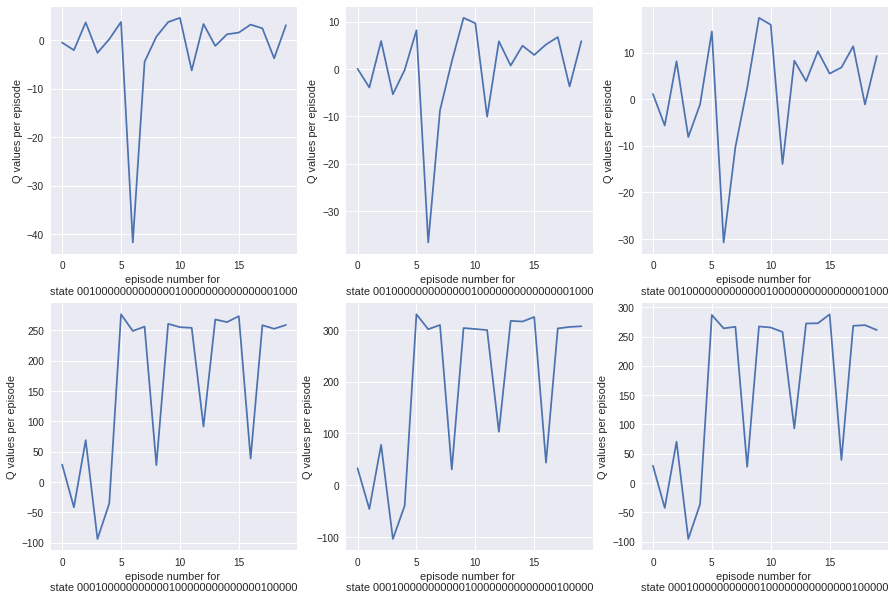

In [25]:
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.plot(list(range(len(States_track[state_keys[2]][3]))), States_track[state_keys[2]][3])
plt.xlabel("episode number for \nstate " +state_keys[2])
plt.ylabel("Q values per episode")
plt.subplot(232)
plt.plot(list(range(len(States_track[state_keys[2]][13]))), States_track[state_keys[2]][13])
plt.xlabel("episode number for \nstate " +state_keys[2])
plt.ylabel("Q values per episode")
plt.subplot(233)
plt.plot(list(range(len(States_track[state_keys[2]][19]))), States_track[state_keys[2]][19])
plt.xlabel("episode number for \nstate " +state_keys[2])
plt.ylabel("Q values per episode")
plt.subplot(234)
plt.plot(list(range(len(States_track[state_keys[1]][3]))), States_track[state_keys[1]][3])
plt.xlabel("episode number for \nstate " +state_keys[1])
plt.ylabel("Q values per episode")
plt.subplot(235)
plt.plot(list(range(len(States_track[state_keys[1]][11]))), States_track[state_keys[1]][11])
plt.xlabel("episode number for \nstate " +state_keys[1])
plt.ylabel("Q values per episode")
plt.subplot(236)
plt.plot(list(range(len(States_track[state_keys[1]][7]))), States_track[state_keys[1]][7])
plt.xlabel("episode number for \nstate " +state_keys[1])
plt.ylabel("Q values per episode")
plt.show()

In [0]:
#=============TODO:

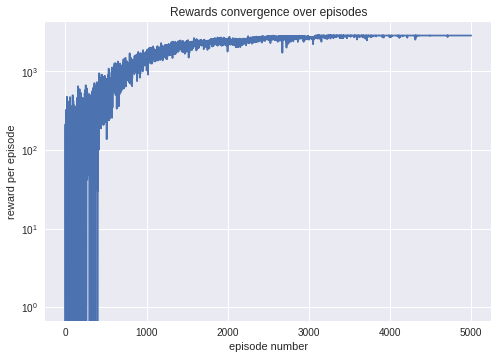

In [27]:
with open('rewards_'+str(Episodes)+'.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.yscale('log')
plt.title("Rewards convergence over episodes")
plt.show()

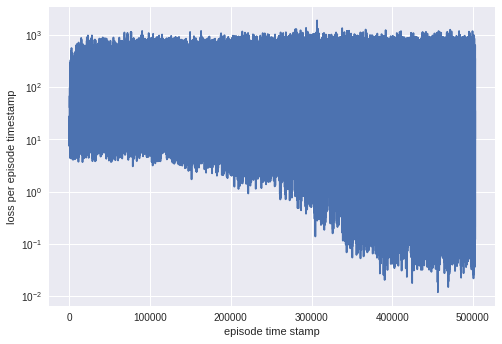

In [28]:
# Tracking loss

plt.plot(list(range(len(agent.track_loss))), agent.track_loss)
plt.xlabel("episode time stamp")
plt.ylabel("loss per episode timestamp")
plt.yscale('log')
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [0]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

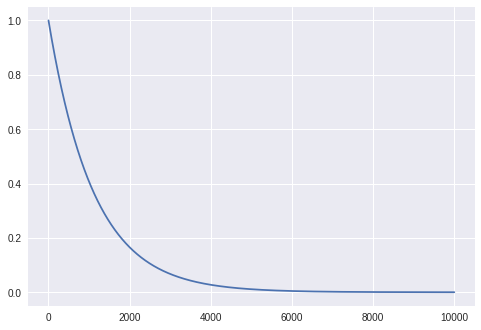

In [30]:
plt.plot(time, epsilon)
plt.show()